In [165]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import random 
import os
from tqdm import tqdm 
import plotly.io as pio
#pio.renderers.default = 'colab'

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.express as px

# Check version
print('torch version: ', torch.__version__)

torch version:  1.9.1


In [166]:
# FashionMNIST Data Download
data_dir = './data'

train_dataset = torchvision.datasets.FashionMNIST(root = data_dir,
                                                  train = True,
                                                  download = True,
                                                  transform = transforms.ToTensor()) 

test_dataset = torchvision.datasets.FashionMNIST(root = data_dir,
                                                 train = False,
                                                 download = True,
                                                 transform = transforms.ToTensor())

# Check Data size
size_of_train  = len(train_dataset)
size_of_test  = len(test_dataset)
num_of_class = 10

print('The Shape of dataset:', train_dataset[0][0].shape)
print('Value MIN: %d, MEAN:%.2f, MAX:%d'%(torch.min(train_dataset[0][0]), torch.mean(train_dataset[0][0]), torch.max(train_dataset[0][0])))
print('The number of train image:', size_of_train)
print('The number of test image:', size_of_test)

The Shape of dataset: torch.Size([1, 28, 28])
Value MIN: 0, MEAN:0.38, MAX:1
The number of train image: 60000
The number of test image: 10000


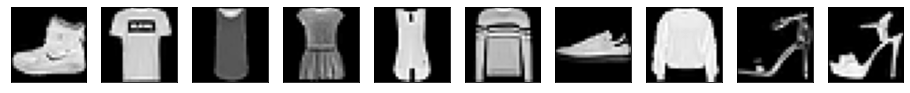

In [167]:
# Train Data
plt.figure(figsize=(16, 10))
for i in range(num_of_class):
    ax = plt.subplot(1, num_of_class, i+1)
    plt.imshow(train_dataset[i][0][0], cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [168]:
# Dataload
# random_split randomly split a dataset into non-overlapping new datasets of given lengths
m=len(train_dataset)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)]) 
# 20:80 비율로 train, val 나눔

batch_size=16

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                           batch_size = batch_size,
                                           shuffle = True)

valid_loader = torch.utils.data.DataLoader(dataset = val_data, 
                                           batch_size = batch_size, 
                                           shuffle = False)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = False)

print('The number of train data:', len(train_data))
print('The number of valid data:', len(val_data))
print('The number of test data:', len(test_dataset))

The number of train data: 48000
The number of valid data: 12000
The number of test data: 10000


In [169]:
# X_train, y_train shape
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type()) 
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

X_train: torch.Size([16, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([16]) type: torch.LongTensor


In [170]:
# Channel Attention & Spatial Attention
# autoencoder_block & channel_attention_block & spatial_attention_block

class Channel_Attention(nn.Module):
    def __init__(self, channel, scale_factor=4):
        super(Channel_Attention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel//scale_factor, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel//scale_factor, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        
        return x * y.expand_as(x)


class Spatial_Attention(nn.Module):   
    def __init__(self, channel):
        super(Spatial_Attention, self).__init__()
        self.conv = nn.Conv2d(channel, 1, kernel_size=3, padding='same', bias=False)
        self.sigmoid = nn.Sigmoid()
            
    def forward(self, x):
        y = self.conv(x)
        y = self.sigmoid(y)
    
        return x * y.expand_as(x)
        

def autoencoder_block(in_channels, out_channels):
    ae_block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same'),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(True)
    )
    return ae_block

def channel_attention_block(input_dim, output_dim):
    ca_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=(1, 1), padding='same'),
        nn.BatchNorm2d(output_dim),
        Channel_Attention(output_dim)
    )
    return ca_block

def spatial_attention_block(input_dim, output_dim):
    sa_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, stride=(1, 1), padding='same'),
        nn.BatchNorm2d(output_dim),
        Spatial_Attention(output_dim),
        nn.ReLU(True)
    )
    return sa_block

In [171]:
# Parallel_Add_Attention & Parallel_Mul_Attention
# parallel_add_autoencoder_block & parallel_mul_autoencoder_block

class Parallel_Add_Attention(nn.Module):   
    def __init__(self, channel, k_size=3):
        super(Parallel_Add_Attention, self).__init__()
        self.CA = Channel_Attention(channel)
        self.SA = Spatial_Attention(channel)
            
    def forward(self, x):
        y1 = self.CA(x)
        y2 = self.SA(x)
    
        return y1 + y2

class Parallel_Mul_Attention(nn.Module):   
    def __init__(self, channel, k_size=3):
        super(Parallel_Mul_Attention, self).__init__()
        self.CA = Channel_Attention(channel)
        self.SA = Spatial_Attention(channel)
            
    def forward(self, x):
        y1 = self.CA(x)
        y2 = self.SA(x)
    
        return y1 * y2
    
def parallel_add_autoencoder_block(input_dim, output_dim):
    pae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, 
                  stride=1, padding='same'),
        Parallel_Add_Attention(output_dim),
        nn.BatchNorm2d(output_dim),
        nn.ReLU()
    )
    return pae_block

def parallel_mul_autoencoder_block(input_dim, output_dim):
    pae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, 
                  stride=1, padding='same'),
        Parallel_Mul_Attention(output_dim),
        nn.BatchNorm2d(output_dim),
        nn.ReLU()
    )
    return pae_block

In [172]:
# Serial_CASA_Attention & Serial_SACA_Attention
# serial_CASA_autoencoder_block & serial_SACA_autoencoder_block

class Serial_CASA_Attention(nn.Module):   
    def __init__(self, channel, k_size=3):
        super(Serial_CASA_Attention, self).__init__()
        self.CA = Channel_Attention(channel)
        self.SA = Spatial_Attention(channel)
            
    def forward(self, x):
        y = self.CA(x)
        y = self.SA(y)
    
        return y

class Serial_SACA_Attention(nn.Module):   
    def __init__(self, channel, k_size=3):
        super(Serial_SACA_Attention, self).__init__()
        self.SA = Spatial_Attention(channel)
        self.CA = Channel_Attention(channel)        
            
    def forward(self, x):
        y = self.SA(x)
        y = self.CA(y)
    
        return y

def serial_CASA_autoencoder_block(input_dim, output_dim):
    sae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, 
                  stride=1, padding='same'),
        Channel_Attention(output_dim),
        Spatial_Attention(output_dim),
        nn.BatchNorm2d(output_dim),
        nn.ReLU()
    )
    return sae_block

def serial_SACA_autoencoder_block(input_dim, output_dim):
    sae_block = nn.Sequential(
        nn.Conv2d(input_dim, output_dim, kernel_size=3, 
                  stride=1, padding='same'),
        Spatial_Attention(output_dim),
        Channel_Attention(output_dim),
        nn.BatchNorm2d(output_dim),
        nn.ReLU()
    )
    return sae_block

In [173]:
# model1: AutoEncoder

class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.auto1 = autoencoder_block(1, 16)
        self.auto2 = autoencoder_block(16, 32)
        self.auto3 = autoencoder_block(32, 64)
        self.auto4 = autoencoder_block(64, 64)
        self.auto5 = autoencoder_block(64, 32)
        self.auto6 = autoencoder_block(32, 16)
        
        self.max_pool2d = nn.MaxPool2d((2, 2))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.auto1(x)                        # (1, 28, 28) -> (16, 28, 28)
        x = self.max_pool2d(x)                   # (16, 28, 28) -> (16, 14, 14)
        x = self.auto2(x)                        # (16, 14, 14) -> (32, 14, 14)
        x = self.max_pool2d(x)                   # (32, 14, 14) -> (32, 7, 7)
        encoded_img = self.auto3(x)              # (32, 7, 7) -> (64, 7, 7)
        
        # decoder
        x = self.auto4(encoded_img)              # (64, 7, 7) -> (64, 7, 7)
        x = self.upsample(x)                     # (64, 7, 7) -> (32, 7, 7)
        x = self.auto5(x)                        # (32, 7, 7) -> (32, 14, 14)
        x = self.upsample(x)                     # (32, 14, 14) -> (16, 14, 14)
        x = self.auto6(x)                        # (16, 14, 14) -> (16, 28, 28)
        decoded_img = self.sigmoid(self.conv(x)) # (16, 28, 28) -> (1, 28, 28)
        
        return decoded_img

In [174]:
# model2: Channel Attention AutoEncoder

class CA_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.auto1 = channel_attention_block(1, 16)
        self.auto2 = channel_attention_block(16, 32)
        self.auto3 = channel_attention_block(32, 64)
        self.auto4 = channel_attention_block(64, 64)
        self.auto5 = channel_attention_block(64, 32)
        self.auto6 = channel_attention_block(32, 16)
        
        self.max_pool2d = nn.MaxPool2d((2, 2))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.auto1(x)                        # (1, 28, 28) -> (16, 28, 28)
        x = self.max_pool2d(x)                   # (16, 28, 28) -> (16, 14, 14)
        x = self.auto2(x)                        # (16, 14, 14) -> (32, 14, 14)
        x = self.max_pool2d(x)                   # (32, 14, 14) -> (32, 7, 7)
        encoded_img = self.auto3(x)              # (32, 7, 7) -> (64, 7, 7)
        
        # decoder
        x = self.auto4(encoded_img)              # (64, 7, 7) -> (64, 7, 7)
        x = self.upsample(x)                     # (64, 7, 7) -> (32, 7, 7)
        x = self.auto5(x)                        # (32, 7, 7) -> (32, 14, 14)
        x = self.upsample(x)                     # (32, 14, 14) -> (16, 14, 14)
        x = self.auto6(x)                        # (16, 14, 14) -> (16, 28, 28)
        decoded_img = self.sigmoid(self.conv(x)) # (16, 28, 28) -> (1, 28, 28)
        
        return decoded_img

In [175]:
# model3: Spatial Attention AutoEncoder

class SA_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.auto1 = spatial_attention_block(1, 16)
        self.auto2 = spatial_attention_block(16, 32)
        self.auto3 = spatial_attention_block(32, 64)
        self.auto4 = spatial_attention_block(64, 64)
        self.auto5 = spatial_attention_block(64, 32)
        self.auto6 = spatial_attention_block(32, 16)
        
        self.max_pool2d = nn.MaxPool2d((2, 2))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.auto1(x)                        # (1, 28, 28) -> (16, 28, 28)
        x = self.max_pool2d(x)                   # (16, 28, 28) -> (16, 14, 14)
        x = self.auto2(x)                        # (16, 14, 14) -> (32, 14, 14)
        x = self.max_pool2d(x)                   # (32, 14, 14) -> (32, 7, 7)
        encoded_img = self.auto3(x)              # (32, 7, 7) -> (64, 7, 7)
        
        # decoder
        x = self.auto4(encoded_img)              # (64, 7, 7) -> (64, 7, 7)
        x = self.upsample(x)                     # (64, 7, 7) -> (32, 7, 7)
        x = self.auto5(x)                        # (32, 7, 7) -> (32, 14, 14)
        x = self.upsample(x)                     # (32, 14, 14) -> (16, 14, 14)
        x = self.auto6(x)                        # (16, 14, 14) -> (16, 28, 28)
        decoded_img = self.sigmoid(self.conv(x)) # (16, 28, 28) -> (1, 28, 28)
        
        return decoded_img

In [176]:
# model4: Parallel Add Attention AutoEncoder

class Parallel_Add_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.auto1 = parallel_add_autoencoder_block(1, 16)
        self.auto2 = parallel_add_autoencoder_block(16, 32)
        self.auto3 = parallel_add_autoencoder_block(32, 64)
        self.auto4 = parallel_add_autoencoder_block(64, 64)
        self.auto5 = parallel_add_autoencoder_block(64, 32)
        self.auto6 = parallel_add_autoencoder_block(32, 16)
        
        self.max_pool2d = nn.MaxPool2d((2, 2))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.auto1(x)                        # (1, 28, 28) -> (16, 28, 28)
        x = self.max_pool2d(x)                   # (16, 28, 28) -> (16, 14, 14)
        x = self.auto2(x)                        # (16, 14, 14) -> (32, 14, 14)
        x = self.max_pool2d(x)                   # (32, 14, 14) -> (32, 7, 7)
        encoded_img = self.auto3(x)              # (32, 7, 7) -> (64, 7, 7)
        
        # decoder
        x = self.auto4(encoded_img)              # (64, 7, 7) -> (64, 7, 7)
        x = self.upsample(x)                     # (64, 7, 7) -> (32, 7, 7)
        x = self.auto5(x)                        # (32, 7, 7) -> (32, 14, 14)
        x = self.upsample(x)                     # (32, 14, 14) -> (16, 14, 14)
        x = self.auto6(x)                        # (16, 14, 14) -> (16, 28, 28)
        decoded_img = self.sigmoid(self.conv(x)) # (16, 28, 28) -> (1, 28, 28)
        
        return decoded_img

In [177]:
# model5: Parallel Mul Attention AutoEncoder

class Parallel_Mul_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.auto1 = parallel_mul_autoencoder_block(1, 16)
        self.auto2 = parallel_mul_autoencoder_block(16, 32)
        self.auto3 = parallel_mul_autoencoder_block(32, 64)
        self.auto4 = parallel_mul_autoencoder_block(64, 64)
        self.auto5 = parallel_mul_autoencoder_block(64, 32)
        self.auto6 = parallel_mul_autoencoder_block(32, 16)
        
        self.max_pool2d = nn.MaxPool2d((2, 2))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.auto1(x)                        # (1, 28, 28) -> (16, 28, 28)
        x = self.max_pool2d(x)                   # (16, 28, 28) -> (16, 14, 14)
        x = self.auto2(x)                        # (16, 14, 14) -> (32, 14, 14)
        x = self.max_pool2d(x)                   # (32, 14, 14) -> (32, 7, 7)
        encoded_img = self.auto3(x)              # (32, 7, 7) -> (64, 7, 7)
        
        # decoder
        x = self.auto4(encoded_img)              # (64, 7, 7) -> (64, 7, 7)
        x = self.upsample(x)                     # (64, 7, 7) -> (32, 7, 7)
        x = self.auto5(x)                        # (32, 7, 7) -> (32, 14, 14)
        x = self.upsample(x)                     # (32, 14, 14) -> (16, 14, 14)
        x = self.auto6(x)                        # (16, 14, 14) -> (16, 28, 28)
        decoded_img = self.sigmoid(self.conv(x)) # (16, 28, 28) -> (1, 28, 28)
        
        return decoded_img

In [178]:
# model6: Serial CASA Attention AutoEncoder

class Serial_CASA_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.auto1 = serial_CASA_autoencoder_block(1, 16)
        self.auto2 = serial_CASA_autoencoder_block(16, 32)
        self.auto3 = serial_CASA_autoencoder_block(32, 64)
        self.auto4 = serial_CASA_autoencoder_block(64, 64)
        self.auto5 = serial_CASA_autoencoder_block(64, 32)
        self.auto6 = serial_CASA_autoencoder_block(32, 16)
        
        self.max_pool2d = nn.MaxPool2d((2, 2))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.auto1(x)                        # (1, 28, 28) -> (16, 28, 28)
        x = self.max_pool2d(x)                   # (16, 28, 28) -> (16, 14, 14)
        x = self.auto2(x)                        # (16, 14, 14) -> (32, 14, 14)
        x = self.max_pool2d(x)                   # (32, 14, 14) -> (32, 7, 7)
        encoded_img = self.auto3(x)              # (32, 7, 7) -> (64, 7, 7)
        
        # decoder
        x = self.auto4(encoded_img)              # (64, 7, 7) -> (64, 7, 7)
        x = self.upsample(x)                     # (64, 7, 7) -> (32, 7, 7)
        x = self.auto5(x)                        # (32, 7, 7) -> (32, 14, 14)
        x = self.upsample(x)                     # (32, 14, 14) -> (16, 14, 14)
        x = self.auto6(x)                        # (16, 14, 14) -> (16, 28, 28)
        decoded_img = self.sigmoid(self.conv(x)) # (16, 28, 28) -> (1, 28, 28)
        
        return decoded_img

In [179]:
# model7: Serial SACA Attention AutoEncoder

class Serial_SACA_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.auto1 = serial_SACA_autoencoder_block(1, 16)
        self.auto2 = serial_SACA_autoencoder_block(16, 32)
        self.auto3 = serial_SACA_autoencoder_block(32, 64)
        self.auto4 = serial_SACA_autoencoder_block(64, 64)
        self.auto5 = serial_SACA_autoencoder_block(64, 32)
        self.auto6 = serial_SACA_autoencoder_block(32, 16)
        
        self.max_pool2d = nn.MaxPool2d((2, 2))
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Conv2d(16, 1, kernel_size=3, stride=(1, 1), padding='same')
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # encoder
        x = self.auto1(x)                        # (1, 28, 28) -> (16, 28, 28)
        x = self.max_pool2d(x)                   # (16, 28, 28) -> (16, 14, 14)
        x = self.auto2(x)                        # (16, 14, 14) -> (32, 14, 14)
        x = self.max_pool2d(x)                   # (32, 14, 14) -> (32, 7, 7)
        encoded_img = self.auto3(x)              # (32, 7, 7) -> (64, 7, 7)
        
        # decoder
        x = self.auto4(encoded_img)              # (64, 7, 7) -> (64, 7, 7)
        x = self.upsample(x)                     # (64, 7, 7) -> (32, 7, 7)
        x = self.auto5(x)                        # (32, 7, 7) -> (32, 14, 14)
        x = self.upsample(x)                     # (32, 14, 14) -> (16, 14, 14)
        x = self.auto6(x)                        # (16, 14, 14) -> (16, 28, 28)
        decoded_img = self.sigmoid(self.conv(x)) # (16, 28, 28) -> (1, 28, 28)
        
        return decoded_img

In [180]:
torch.manual_seed(0)

model1 = AutoEncoder()
model2 = CA_AutoEncoder()
model3 = SA_AutoEncoder()
model4 = Parallel_Add_AutoEncoder()
model5 = Parallel_Mul_AutoEncoder()
model6 = Serial_CASA_AutoEncoder()
model7 = Serial_SACA_AutoEncoder()

In [181]:
# torchsummary install 필요
# !pip install torchsummary

In [182]:
import torchsummary
torchsummary.summary(model1, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         MaxPool2d-4           [-1, 16, 14, 14]               0
            Conv2d-5           [-1, 32, 14, 14]           4,640
       BatchNorm2d-6           [-1, 32, 14, 14]              64
              ReLU-7           [-1, 32, 14, 14]               0
         MaxPool2d-8             [-1, 32, 7, 7]               0
            Conv2d-9             [-1, 64, 7, 7]          18,496
      BatchNorm2d-10             [-1, 64, 7, 7]             128
             ReLU-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,928
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [183]:
torchsummary.summary(model2, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
 AdaptiveAvgPool2d-3             [-1, 16, 1, 1]               0
            Linear-4                    [-1, 4]              64
              ReLU-5                    [-1, 4]               0
            Linear-6                   [-1, 16]              64
           Sigmoid-7                   [-1, 16]               0
 Channel_Attention-8           [-1, 16, 28, 28]               0
         MaxPool2d-9           [-1, 16, 14, 14]               0
           Conv2d-10           [-1, 32, 14, 14]           4,640
      BatchNorm2d-11           [-1, 32, 14, 14]              64
AdaptiveAvgPool2d-12             [-1, 32, 1, 1]               0
           Linear-13                    [-1, 8]             256
             ReLU-14                   

In [184]:
torchsummary.summary(model3, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
       BatchNorm2d-2           [-1, 16, 28, 28]              32
            Conv2d-3            [-1, 1, 28, 28]             144
           Sigmoid-4            [-1, 1, 28, 28]               0
 Spatial_Attention-5           [-1, 16, 28, 28]               0
              ReLU-6           [-1, 16, 28, 28]               0
         MaxPool2d-7           [-1, 16, 14, 14]               0
            Conv2d-8           [-1, 32, 14, 14]           4,640
       BatchNorm2d-9           [-1, 32, 14, 14]              64
           Conv2d-10            [-1, 1, 14, 14]             288
          Sigmoid-11            [-1, 1, 14, 14]               0
Spatial_Attention-12           [-1, 32, 14, 14]               0
             ReLU-13           [-1, 32, 14, 14]               0
        MaxPool2d-14             [-1, 3

In [185]:
torchsummary.summary(model4, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
 AdaptiveAvgPool2d-2             [-1, 16, 1, 1]               0
            Linear-3                    [-1, 4]              64
              ReLU-4                    [-1, 4]               0
            Linear-5                   [-1, 16]              64
           Sigmoid-6                   [-1, 16]               0
 Channel_Attention-7           [-1, 16, 28, 28]               0
            Conv2d-8            [-1, 1, 28, 28]             144
           Sigmoid-9            [-1, 1, 28, 28]               0
Spatial_Attention-10           [-1, 16, 28, 28]               0
Parallel_Add_Attention-11           [-1, 16, 28, 28]               0
      BatchNorm2d-12           [-1, 16, 28, 28]              32
             ReLU-13           [-1, 16, 28, 28]               0
        MaxPool2d-14           [-1

In [186]:
torchsummary.summary(model5, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
 AdaptiveAvgPool2d-2             [-1, 16, 1, 1]               0
            Linear-3                    [-1, 4]              64
              ReLU-4                    [-1, 4]               0
            Linear-5                   [-1, 16]              64
           Sigmoid-6                   [-1, 16]               0
 Channel_Attention-7           [-1, 16, 28, 28]               0
            Conv2d-8            [-1, 1, 28, 28]             144
           Sigmoid-9            [-1, 1, 28, 28]               0
Spatial_Attention-10           [-1, 16, 28, 28]               0
Parallel_Mul_Attention-11           [-1, 16, 28, 28]               0
      BatchNorm2d-12           [-1, 16, 28, 28]              32
             ReLU-13           [-1, 16, 28, 28]               0
        MaxPool2d-14           [-1

In [187]:
torchsummary.summary(model6, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
 AdaptiveAvgPool2d-2             [-1, 16, 1, 1]               0
            Linear-3                    [-1, 4]              64
              ReLU-4                    [-1, 4]               0
            Linear-5                   [-1, 16]              64
           Sigmoid-6                   [-1, 16]               0
 Channel_Attention-7           [-1, 16, 28, 28]               0
            Conv2d-8            [-1, 1, 28, 28]             144
           Sigmoid-9            [-1, 1, 28, 28]               0
Spatial_Attention-10           [-1, 16, 28, 28]               0
      BatchNorm2d-11           [-1, 16, 28, 28]              32
             ReLU-12           [-1, 16, 28, 28]               0
        MaxPool2d-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 32,

In [188]:
torchsummary.summary(model7, (1, 28, 28), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2            [-1, 1, 28, 28]             144
           Sigmoid-3            [-1, 1, 28, 28]               0
 Spatial_Attention-4           [-1, 16, 28, 28]               0
 AdaptiveAvgPool2d-5             [-1, 16, 1, 1]               0
            Linear-6                    [-1, 4]              64
              ReLU-7                    [-1, 4]               0
            Linear-8                   [-1, 16]              64
           Sigmoid-9                   [-1, 16]               0
Channel_Attention-10           [-1, 16, 28, 28]               0
      BatchNorm2d-11           [-1, 16, 28, 28]              32
             ReLU-12           [-1, 16, 28, 28]               0
        MaxPool2d-13           [-1, 16, 14, 14]               0
           Conv2d-14           [-1, 32,

In [189]:
# Take an input image (remember to add the batch dimension)
img, _ = test_dataset[0]
img = img.unsqueeze(0) # Add the batch dimension in the first axis
print('Original image shape:', img.shape)

# AE to the image
img_ae1 = model1(img)
img_ae2 = model2(img)
img_ae3 = model3(img)
img_ae4 = model4(img)
img_ae5 = model5(img)
img_ae6 = model6(img)
img_ae7 = model7(img)

print('AE image1 shape:', img_ae1.shape)
print('AE image2 shape:', img_ae2.shape)
print('AE image3 shape:', img_ae3.shape)
print('AE image4 shape:', img_ae4.shape)
print('AE image5 shape:', img_ae5.shape)
print('AE image6 shape:', img_ae6.shape)
print('AE image7 shape:', img_ae7.shape)

Original image shape: torch.Size([1, 1, 28, 28])
AE image1 shape: torch.Size([1, 1, 28, 28])
AE image2 shape: torch.Size([1, 1, 28, 28])
AE image3 shape: torch.Size([1, 1, 28, 28])
AE image4 shape: torch.Size([1, 1, 28, 28])
AE image5 shape: torch.Size([1, 1, 28, 28])
AE image6 shape: torch.Size([1, 1, 28, 28])
AE image7 shape: torch.Size([1, 1, 28, 28])


In [190]:
### Define the loss function
loss_fn1 = torch.nn.MSELoss()
loss_fn2 = torch.nn.MSELoss()
loss_fn3 = torch.nn.MSELoss()
loss_fn4 = torch.nn.MSELoss()
loss_fn5 = torch.nn.MSELoss()
loss_fn6 = torch.nn.MSELoss()
loss_fn7 = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr = 0.001 # Learning rate

optim1 = torch.optim.Adam(model1.parameters(), lr=lr, weight_decay=1e-05)
optim2 = torch.optim.Adam(model2.parameters(), lr=lr, weight_decay=1e-05)
optim3 = torch.optim.Adam(model3.parameters(), lr=lr, weight_decay=1e-05)
optim4 = torch.optim.Adam(model4.parameters(), lr=lr, weight_decay=1e-05)
optim5 = torch.optim.Adam(model5.parameters(), lr=lr, weight_decay=1e-05)
optim6 = torch.optim.Adam(model6.parameters(), lr=lr, weight_decay=1e-05)
optim7 = torch.optim.Adam(model7.parameters(), lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
model1 = model1.to(device)
model2 = model2.to(device)
model3 = model3.to(device)
model4 = model4.to(device)
model5 = model5.to(device)
model6 = model6.to(device)
model7 = model7.to(device)

Selected device: cuda


In [191]:
#Training function
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    model.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Decode data
        decoded_data = model(image_batch)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

In [192]:
### Testing function
def test_epoch(model, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Decode data
            decoded_data = model(image_batch)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [193]:
def plot_ae_outputs(model, n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)
        model.eval()
        with torch.no_grad():
            rec_img = model(img)
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()

In [194]:
# model1

num_epochs = 5
history1 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model1, device, train_loader, loss_fn1, optim1)
    val_loss = test_epoch(model1, device, test_loader, loss_fn1)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history1['train_loss'].append(train_loss)
    history1['val_loss'].append(val_loss)


 EPOCH 1/5 	 train loss 0.008 	 val loss 0.006

 EPOCH 2/5 	 train loss 0.004 	 val loss 0.004

 EPOCH 3/5 	 train loss 0.004 	 val loss 0.003

 EPOCH 4/5 	 train loss 0.003 	 val loss 0.003

 EPOCH 5/5 	 train loss 0.003 	 val loss 0.004


In [195]:
# model2

num_epochs = 5
history2 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model2, device, train_loader, loss_fn2, optim2)
    val_loss = test_epoch(model2, device, test_loader, loss_fn2)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history2['train_loss'].append(train_loss)
    history2['val_loss'].append(val_loss)


 EPOCH 1/5 	 train loss 0.012 	 val loss 0.007

 EPOCH 2/5 	 train loss 0.007 	 val loss 0.006

 EPOCH 3/5 	 train loss 0.006 	 val loss 0.006

 EPOCH 4/5 	 train loss 0.006 	 val loss 0.005

 EPOCH 5/5 	 train loss 0.006 	 val loss 0.005


In [196]:
# model3

num_epochs = 5
history3 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model3, device, train_loader, loss_fn3, optim3)
    val_loss = test_epoch(model3, device, test_loader, loss_fn3)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history3['train_loss'].append(train_loss)
    history3['val_loss'].append(val_loss)


 EPOCH 1/5 	 train loss 0.009 	 val loss 0.005

 EPOCH 2/5 	 train loss 0.005 	 val loss 0.004

 EPOCH 3/5 	 train loss 0.004 	 val loss 0.004

 EPOCH 4/5 	 train loss 0.004 	 val loss 0.004

 EPOCH 5/5 	 train loss 0.003 	 val loss 0.003


In [197]:
# model4

num_epochs = 5
history4 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model4, device, train_loader, loss_fn4, optim4)
    val_loss = test_epoch(model4, device, test_loader, loss_fn4)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history4['train_loss'].append(train_loss)
    history4['val_loss'].append(val_loss)


 EPOCH 1/5 	 train loss 0.008 	 val loss 0.005

 EPOCH 2/5 	 train loss 0.004 	 val loss 0.004

 EPOCH 3/5 	 train loss 0.004 	 val loss 0.004

 EPOCH 4/5 	 train loss 0.003 	 val loss 0.003

 EPOCH 5/5 	 train loss 0.003 	 val loss 0.003


In [198]:
# model5

num_epochs = 5
history5 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model5, device, train_loader, loss_fn5, optim5)
    val_loss = test_epoch(model5, device, test_loader, loss_fn5)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history5['train_loss'].append(train_loss)
    history5['val_loss'].append(val_loss)


 EPOCH 1/5 	 train loss 0.015 	 val loss 0.006

 EPOCH 2/5 	 train loss 0.005 	 val loss 0.004

 EPOCH 3/5 	 train loss 0.004 	 val loss 0.004

 EPOCH 4/5 	 train loss 0.004 	 val loss 0.004

 EPOCH 5/5 	 train loss 0.003 	 val loss 0.003


In [199]:
# model6

num_epochs = 5
history6 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model6, device, train_loader, loss_fn6, optim6)
    val_loss = test_epoch(model6, device, test_loader, loss_fn6)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history6['train_loss'].append(train_loss)
    history6['val_loss'].append(val_loss)


 EPOCH 1/5 	 train loss 0.008 	 val loss 0.004

 EPOCH 2/5 	 train loss 0.004 	 val loss 0.004

 EPOCH 3/5 	 train loss 0.004 	 val loss 0.004

 EPOCH 4/5 	 train loss 0.003 	 val loss 0.003

 EPOCH 5/5 	 train loss 0.003 	 val loss 0.003


In [200]:
# model7

num_epochs = 5
history7 = {'train_loss':[], 'val_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(model7, device, train_loader, loss_fn7, optim7)
    val_loss = test_epoch(model7, device, test_loader, loss_fn7)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch+1, num_epochs, train_loss, val_loss))
    history7['train_loss'].append(train_loss)
    history7['val_loss'].append(val_loss)


 EPOCH 1/5 	 train loss 0.008 	 val loss 0.005

 EPOCH 2/5 	 train loss 0.004 	 val loss 0.004

 EPOCH 3/5 	 train loss 0.004 	 val loss 0.004

 EPOCH 4/5 	 train loss 0.003 	 val loss 0.004

 EPOCH 5/5 	 train loss 0.003 	 val loss 0.003


<Figure size 1152x720 with 0 Axes>

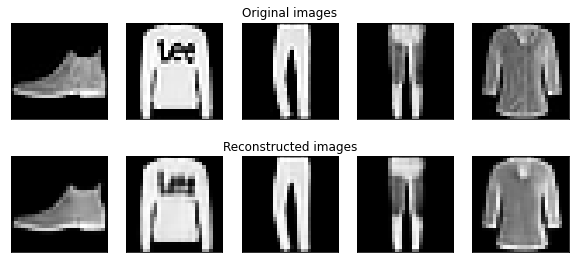

In [201]:
# model1: AutoEncoder
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model1, n=5)

<Figure size 1152x720 with 0 Axes>

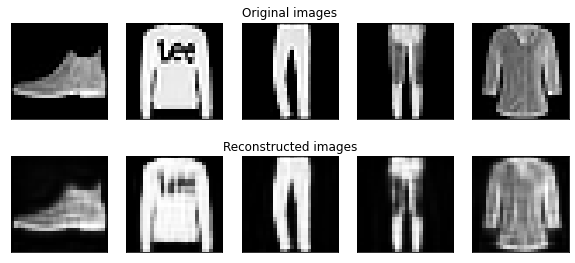

In [202]:
# model2: Channel Attention AutoEncoder
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model2, n=5)

<Figure size 1152x720 with 0 Axes>

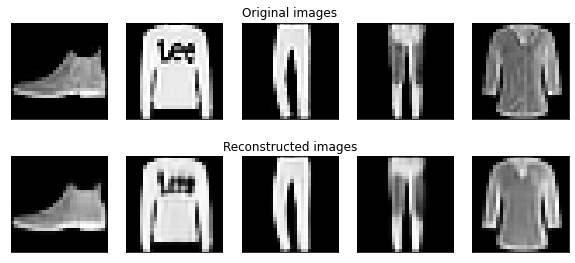

In [203]:
# model3: Spatial Attention AutoEncoder
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model3, n=5)

<Figure size 1152x720 with 0 Axes>

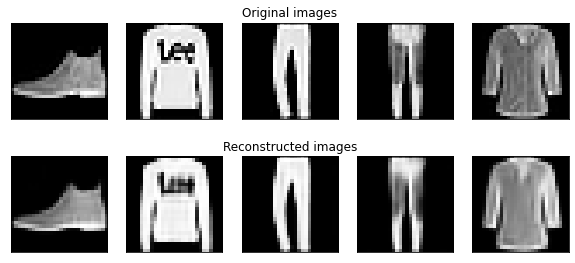

In [204]:
# model4: Parallel Add Attention AutoEncoder
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model4, n=5)

<Figure size 1152x720 with 0 Axes>

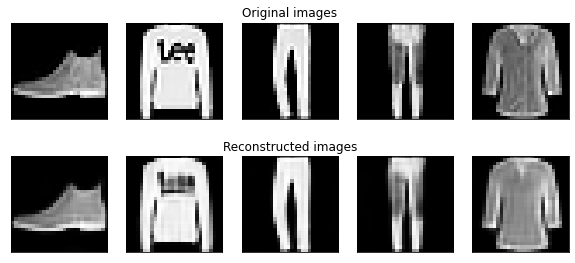

In [205]:
# model5: Parallel Mul Attention AutoEncoder
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model5, n=5)

<Figure size 1152x720 with 0 Axes>

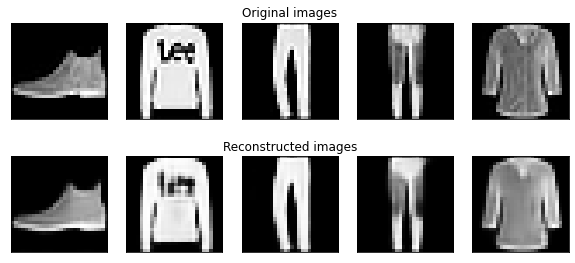

In [206]:
# model6: Serial CASA Attention AutoEncoder
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model6, n=5)

<Figure size 1152x720 with 0 Axes>

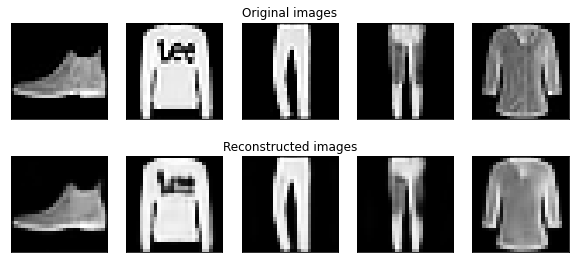

In [207]:
# model7: Serial SACA Attention AutoEncoder
# Test Data vs Predictions Visualization
fig = plt.figure(figsize=(16, 10))
plot_ae_outputs(model7, n=5)

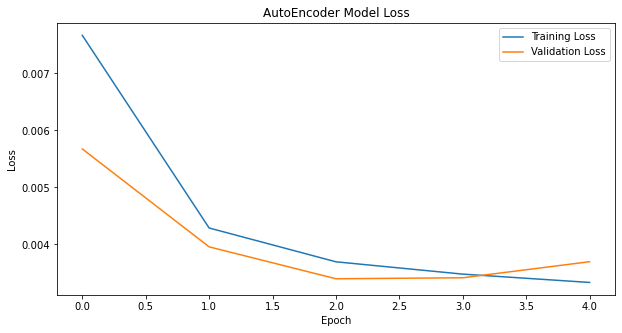

In [208]:
# model1: AutoEncoder

plt.figure(figsize=(10, 5))

plt.plot(history1['train_loss'])
plt.plot(history1['val_loss'])
plt.title('AutoEncoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

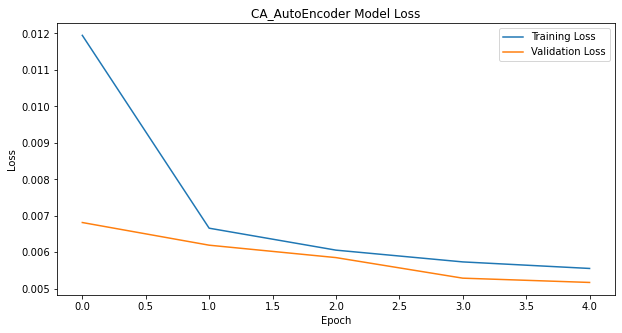

In [209]:
# model2: Channel Attention AutoEncoder

plt.figure(figsize=(10, 5))

plt.plot(history2['train_loss'])
plt.plot(history2['val_loss'])
plt.title('CA_AutoEncoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

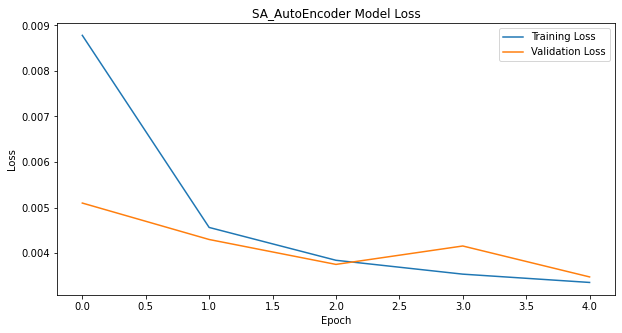

In [210]:
# model3: Spatial Attention AutoEncoder

plt.figure(figsize=(10, 5))

plt.plot(history3['train_loss'])
plt.plot(history3['val_loss'])
plt.title('SA_AutoEncoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

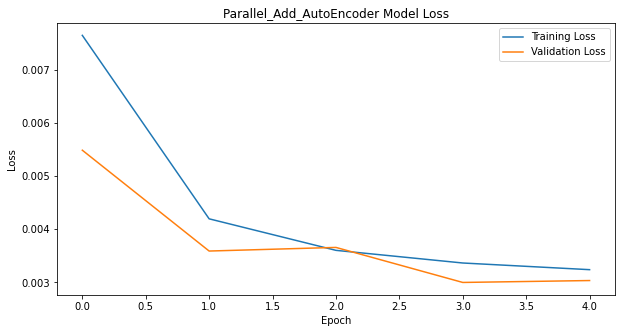

In [211]:
# model4: Parallel Add Attention AutoEncoder

plt.figure(figsize=(10, 5))

plt.plot(history4['train_loss'])
plt.plot(history4['val_loss'])
plt.title('Parallel_Add_AutoEncoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

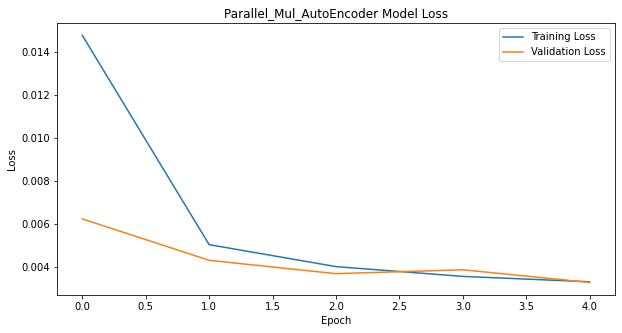

In [212]:
# model5: Parallel Mul Attention AutoEncoder

plt.figure(figsize=(10, 5))

plt.plot(history5['train_loss'])
plt.plot(history5['val_loss'])
plt.title('Parallel_Mul_AutoEncoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

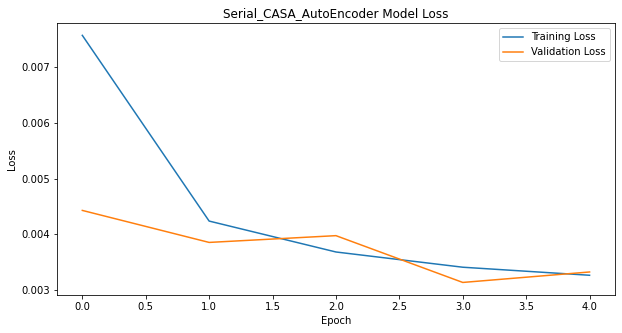

In [213]:
# model6: Serial CASA Attention AutoEncoder

plt.figure(figsize=(10, 5))

plt.plot(history6['train_loss'])
plt.plot(history6['val_loss'])
plt.title('Serial_CASA_AutoEncoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()

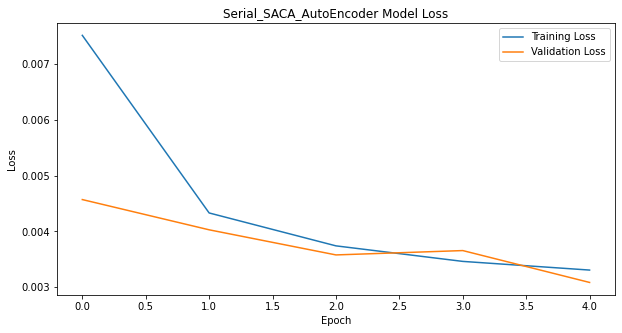

In [214]:
# model7: Serial SACA Attention AutoEncoder

plt.figure(figsize=(10, 5))

plt.plot(history7['train_loss'])
plt.plot(history7['val_loss'])
plt.title('Serial_SACA_AutoEncoder Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc=0)

plt.show()